In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import importlib
from IPython.display import HTML

%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

In [2]:
# Fundamental constants
h    = 6.62607015e-34
GHz = 1e9
e0   = 1.602176634e-19
Φ_0 = h/(2*e0)

# KIT's qubit

This notebook studies the qubit proposed by KIT. It's lumped element model is:
<img src='Other/Single qubit 4 nodes CC coupled to ground.jpg' width='500'>


# Circuit definitions
## Qubit

In [3]:
# Circuit parameters
Csh = 15
C   = 15
Cg  = 10
CJ  = 3
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0
l = Lq*(Lq+4*Lr) - 4*Δ**2

In [4]:
qubit = sq_ext.KIT_qubit()
loop = qubit.loops[0]
qubit.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
sq_ext.print_flux_transformation(qubit)

Φ_1 = [ 0.00  0.00  1.00]
Φ_2 = [ 1.00  0.98  0.61]
Φ_3 = [-0.93  1.00  0.02]


# Equivalent circuits

### Equivalent circuit constructed as a fluxonium + resonator without coupling

In [6]:
loop_eq_fluxonium = sq.Loop(0.5)
loop_eq_ficticious = sq.Loop(0.5)

C_r_eq = sq.Capacitor(C / 2, 'fF')
L_r_eq = sq.Inductor(l / Lq, 'nH')

C_f_eq = sq.Capacitor(C / 2 + Csh + CJ, 'fF')
L_f_eq = sq.Inductor(l / (Lq + 4 * Lr), 'nH', loops=[loop_eq_ficticious])
JJ_f_eq = sq.Junction(EJ, 'GHz', loops=[loop_eq_fluxonium])

equiv_elements = {
    (0, 1): [C_r_eq, L_r_eq, C_f_eq, L_f_eq, JJ_f_eq],
}
qubit_unc = sq.Circuit(equiv_elements)
qubit_unc.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Equivalent circuit constructed as a fluxonium + resonator + coupling

In [7]:
loop_eq_fluxonium = sq.Loop(0.5)
loop_eq_ficticious = sq.Loop(0.5)

C_r_eq = sq.Capacitor(C / 2, 'fF')
L_r_eq = sq.Inductor(1 / (1 / (l / Lq) - 1 / (l / Δ)), 'nH')

C_f_eq = sq.Capacitor(C / 2 + Csh + CJ, 'fF')
L_f_eq = sq.Inductor(1 / (1 / (l / (Lq + 4 * Lr)) - 1 / (l / Δ)), 'nH', loops=[loop_eq_fluxonium, loop_eq_ficticious])
JJ_f_eq = sq.Junction(EJ, 'GHz', loops=[loop_eq_fluxonium])

L_c_eq = sq.Inductor(l / Δ, 'nH')

equiv_elements = {
    (0, 1): [C_r_eq, L_r_eq],
    (1, 2): [L_c_eq],
    (0, 2): [C_f_eq, L_f_eq, JJ_f_eq],
}
qubit_equiv = sq.Circuit(equiv_elements)
qubit_equiv.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
sq_ext.print_flux_transformation(qubit_equiv)

Φ_1 = [-1.00  0.00]
Φ_2 = [ 0.02  1.00]


### Resonator

In [9]:
resonator_elements = {
    (0, 1): [sq.Capacitor(C/2, 'fF'), sq.Inductor (l/Lq, 'nH')],
}
resonator = sq.Circuit(resonator_elements )
resonator.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Fluxonium

In [10]:
loop_fluxonium = sq.Loop(0.5)
fluxonium_elements = {
    (0, 1): [sq.Capacitor(C/2 + Csh + CJ, 'fF'), 
             sq.Inductor(l/(Lq+4*Lr), 'nH', loops=[loop_fluxonium]),
             sq.Junction(EJ, 'GHz', loops=[loop_fluxonium])],
}
fluxonium = sq.Circuit(fluxonium_elements)
fluxonium.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Spectrum

## Resonator spectrum

In [11]:
L_r = l/Lq * 1e-9
C_r = C/2 * 1e-15
w_r = 1/np.sqrt(L_r*C_r) / 2 / np.pi / 1e9
E_harm = w_r * np.arange(0,8)
E_harm

array([0.0e+00, 7.2e+00, 1.4e+01, 2.2e+01, 2.9e+01, 3.6e+01, 4.3e+01, 5.0e+01])

## Spectrum vs external flux

In [12]:
qubit.set_trunc_nums([1, 5, 10])
fluxonium.set_trunc_nums([10])

# spectrum of the qubit
# phi = np.linspace(0,1,200)
#
phi = np.concatenate((np.linspace(0,0.36,50),np.linspace(0.36,0.38,50), np.linspace(0.38,0.46,10), np.linspace(0.46,0.47,50), np.linspace(0.5,1,50)))
n_eig=8
E_circuit = np.zeros((n_eig, len(phi)))
E_fluxonium = np.zeros((n_eig, len(phi)))

eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))
for i in range(len(phi)):
    # set the external flux for the loop
    loop_fluxonium.set_flux(phi[i])
    loop.set_flux(phi[i])
    # diagonalize the qubit
    E_circuit[:, i] = qubit.diag(n_eig)[0]
    E_fluxonium[:, i] = fluxonium.diag(n_eig)[0]

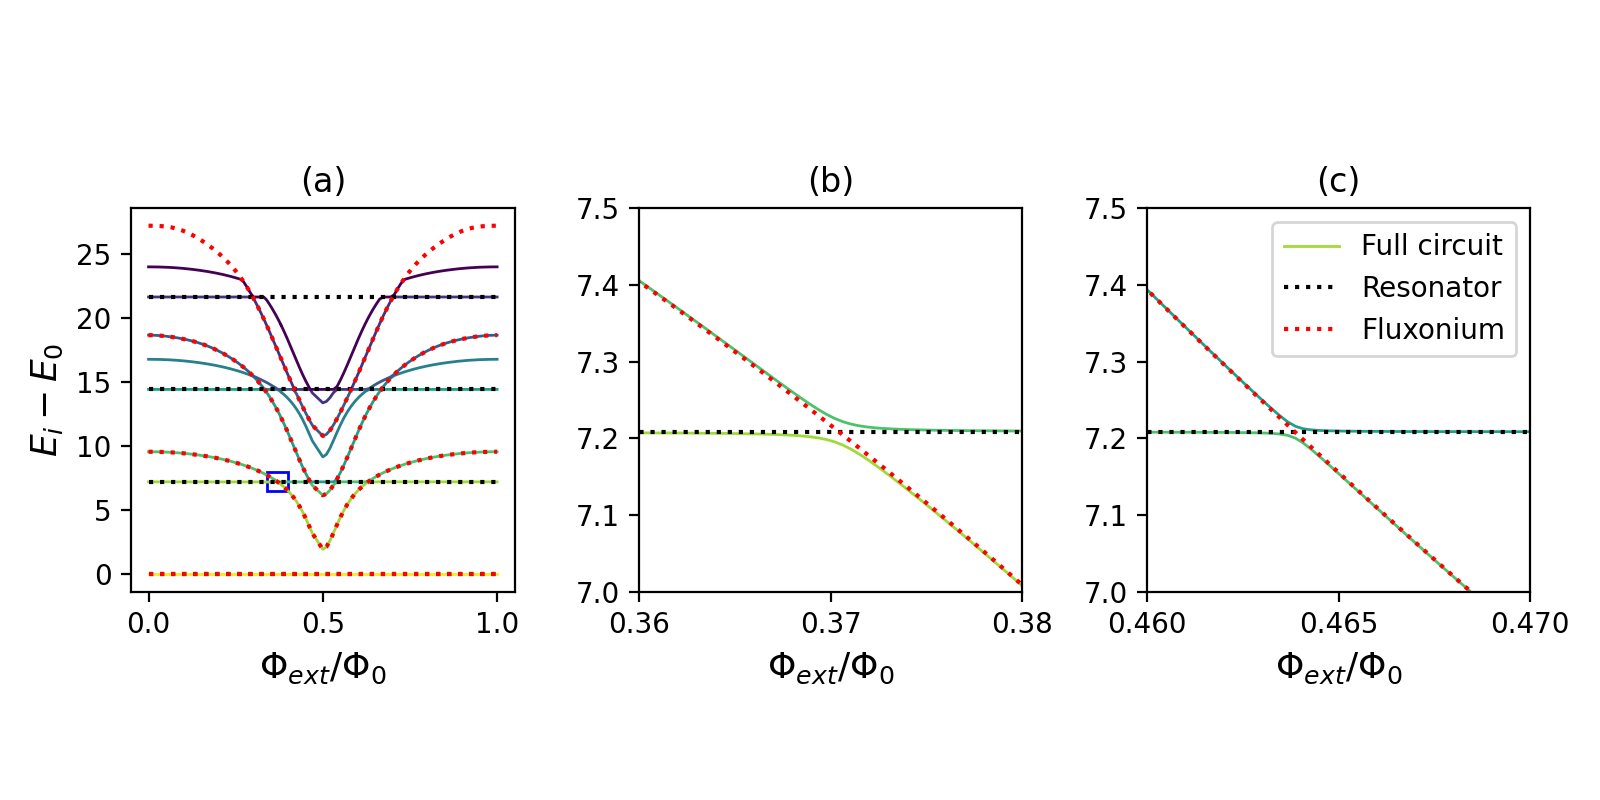

In [13]:
import matplotlib.patches as patches

# Create a rectangle with no fill

fig, axs = plt.subplots(dpi=200, ncols=3, figsize = [8,4])

for ax in axs:
    for i in range(n_eig):
        if i ==1:
            ax.plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i], linewidth=1, label='Full circuit')
        else:
            ax.plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i], linewidth=1)
    for i in range(n_eig//2):
        if i ==0:
            ax.plot([phi[0],phi[-1]], [E_harm[i],E_harm[i]], ':k' , label='Resonator')
            ax.plot(phi, E_fluxonium[i,:]- E_fluxonium[0,:], color='r', linestyle = ':', label='Fluxonium')
        else:
            ax.plot([phi[0],phi[-1]], [E_harm[i],E_harm[i]], ':k' )
            ax.plot(phi, E_fluxonium[i,:]- E_fluxonium[0,:], color='r', linestyle = ':')

    ax.set_box_aspect(1)
    ax.set_xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=13)
    if ax == axs[0]:
        rect = patches.Rectangle((0.34, 6.5), 0.06, 1.5, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.set_title('(a)')
        ax.set_ylabel(r"$E_i-E_0$", fontsize=13)
    elif ax == axs[1]:
        ax.set_title('(b)')
        ax.set_xlim(0.36,0.38)
        ax.set_ylim(7,7.5)

    else :
        ax.set_title('(c)')
        ax.set_xlim(0.46,0.47)
        ax.set_ylim(7,7.5)
        ax.set_xticks([0.46, 0.465, 0.47])
        ax.legend()
fig.tight_layout()
fig.show()
# figs.export('Spectrum.pdf')

# Eigenstates

In [14]:
fig_eigs, axs_eigs = plt.subplots(nrows=2, ncols=2)
axs_eigs[0,0].set_title('(a)')
axs_eigs[0,1].set_title('(b)')
axs_eigs[1,0].set_title('(c)')
axs_eigs[1,1].set_title('(d)')

Text(0.5, 1.0, '(d)')

## Potential energy and eigenstates resoantor

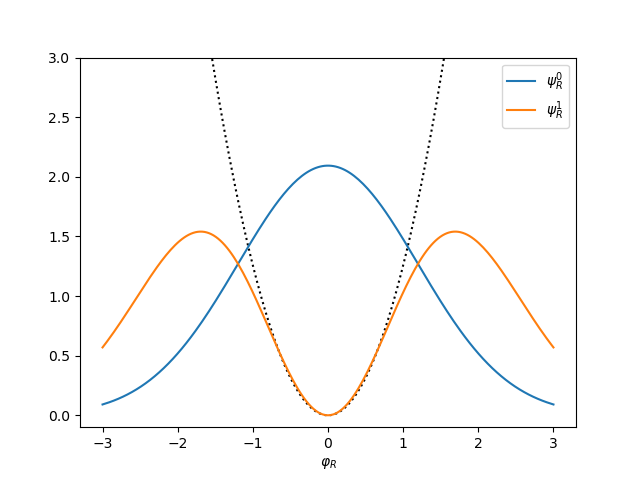

In [15]:
E_L_r = (Φ_0/(2*np.pi))**2/L_r / h

φ_r = np.linspace(-3,3,200)
n_eig = 2

V_r = 0.5 * E_L_r * (φ_r)**2

resonator.set_trunc_nums([20])
_, _ = resonator.diag(n_eig)

states_r = [resonator.eig_phase_coord(k=i, grid=[φ_r/2/np.pi]) for i in range(n_eig)]
labels_r = [r'$\psi_R^0$', r'$\psi_R^1$']

fig, ax_r = plt.subplots()
for ax in [ax_r, axs_eigs[0,0]]:
    ax.plot(φ_r, (V_r-V_r.min())/1e9, 'k:')#, label = r'$\frac{1}{2}E_{L_{R}}\varphi_R^2$')
    [ax.plot(φ_r, np.abs(state)**2, label = label) for state, label in zip(states_r, labels_r)]
    ax.set_ylim([-.1,3])
    ax.set_xlabel(r'$\varphi_R$')
    ax.legend()
fig.show()

## Potential energy and eigenstates of the fluxonium


In [16]:
L_q = l / (Lq + 4*Lr) * 1e-9
E_J = EJ * 1e9

In [17]:
E_L_f = (Φ_0/(2*np.pi))**2/L_q / h
E_C = e0**2 / (2*(C/2 + Csh + CJ)*1e-15) / h

In [18]:
print(E_L_f/GHz, E_C/GHz, E_J/GHz)

6.53862146295341 0.7596168362611421 10.0


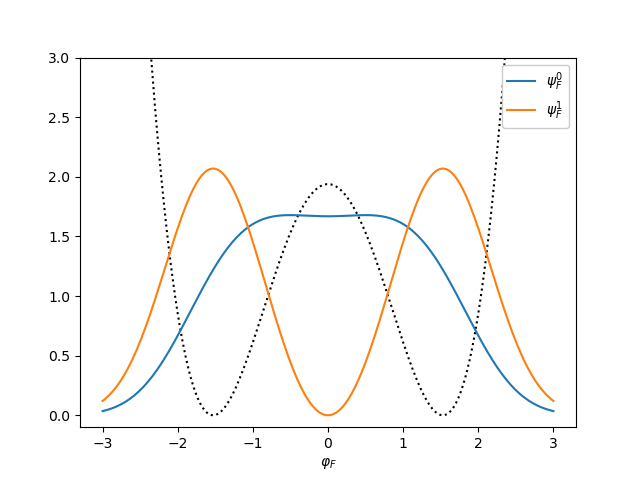

In [19]:
φ_f = np.linspace(-3,3,200)
φ_ext = np.pi
V_f = 0.5 * E_L_f * (φ_f)**2 - E_J * np.cos(φ_f-φ_ext)

n_eig = 2
fluxonium.set_trunc_nums([20])
loop_fluxonium.set_flux(φ_ext/2/np.pi)
_, _ = fluxonium.diag(n_eig)
states_f = [fluxonium.eig_phase_coord(k=i, grid=[φ_f/2/np.pi]) for i in range(n_eig)]
# states_f = [fluxonium.eig_phase_coord(k=i, grid=[φ_q]) for i in range(n_eig)]
labels_f = [r'$\psi_F^0$', r'$\psi_F^1$']

fig, ax_f = plt.subplots()
for ax in [ax_f, axs_eigs[0,1]]:
    ax.plot(φ_r, (V_f-V_f.min())/1e9, 'k:')#, label = r'$\frac{1}{2}E_{L_{F}}\varphi_F^2 - E_J\cos(\varphi_F-\varphi_{ext})$')
    [ax.plot(φ_f, np.abs(state)**2, label = label) for state, label in zip(states_f, labels_f)]
    ax.set_ylim([-.1,3])
    ax.set_xlabel(r'$\varphi_F$')
    ax.legend(loc=1, framealpha=1)

fig.show()

## Eigenstates of the qubit in phase base

In [20]:
qubit.set_trunc_nums([1,5,10])

# creat the phase grid
phi1 = 0
phi2 = np.linspace(-.03, .03, 100)
phi3 = np.linspace(-3, 3 , 100)
grid = [phi1, phi2/2/np.pi, phi3/2/np.pi]

state0_vs_ext_flux = []
state1_vs_ext_flux = []
state2_vs_ext_flux = []
state3_vs_ext_flux = []

ext_flux_list = [0.5, 0.55, 0.65, 1]
# loop thorugh several values of external flux
for ext_flux in ext_flux_list:
    loop.set_flux(ext_flux)
    _, _ = qubit.diag(n_eig=5)

    # Calculate eigenstates in phase coord
    state0_vs_ext_flux.append(qubit.eig_phase_coord(0, grid=grid))
    state1_vs_ext_flux.append(qubit.eig_phase_coord(1, grid=grid))
    state2_vs_ext_flux.append(qubit.eig_phase_coord(2, grid=grid))
    state3_vs_ext_flux.append(qubit.eig_phase_coord(3, grid=grid))

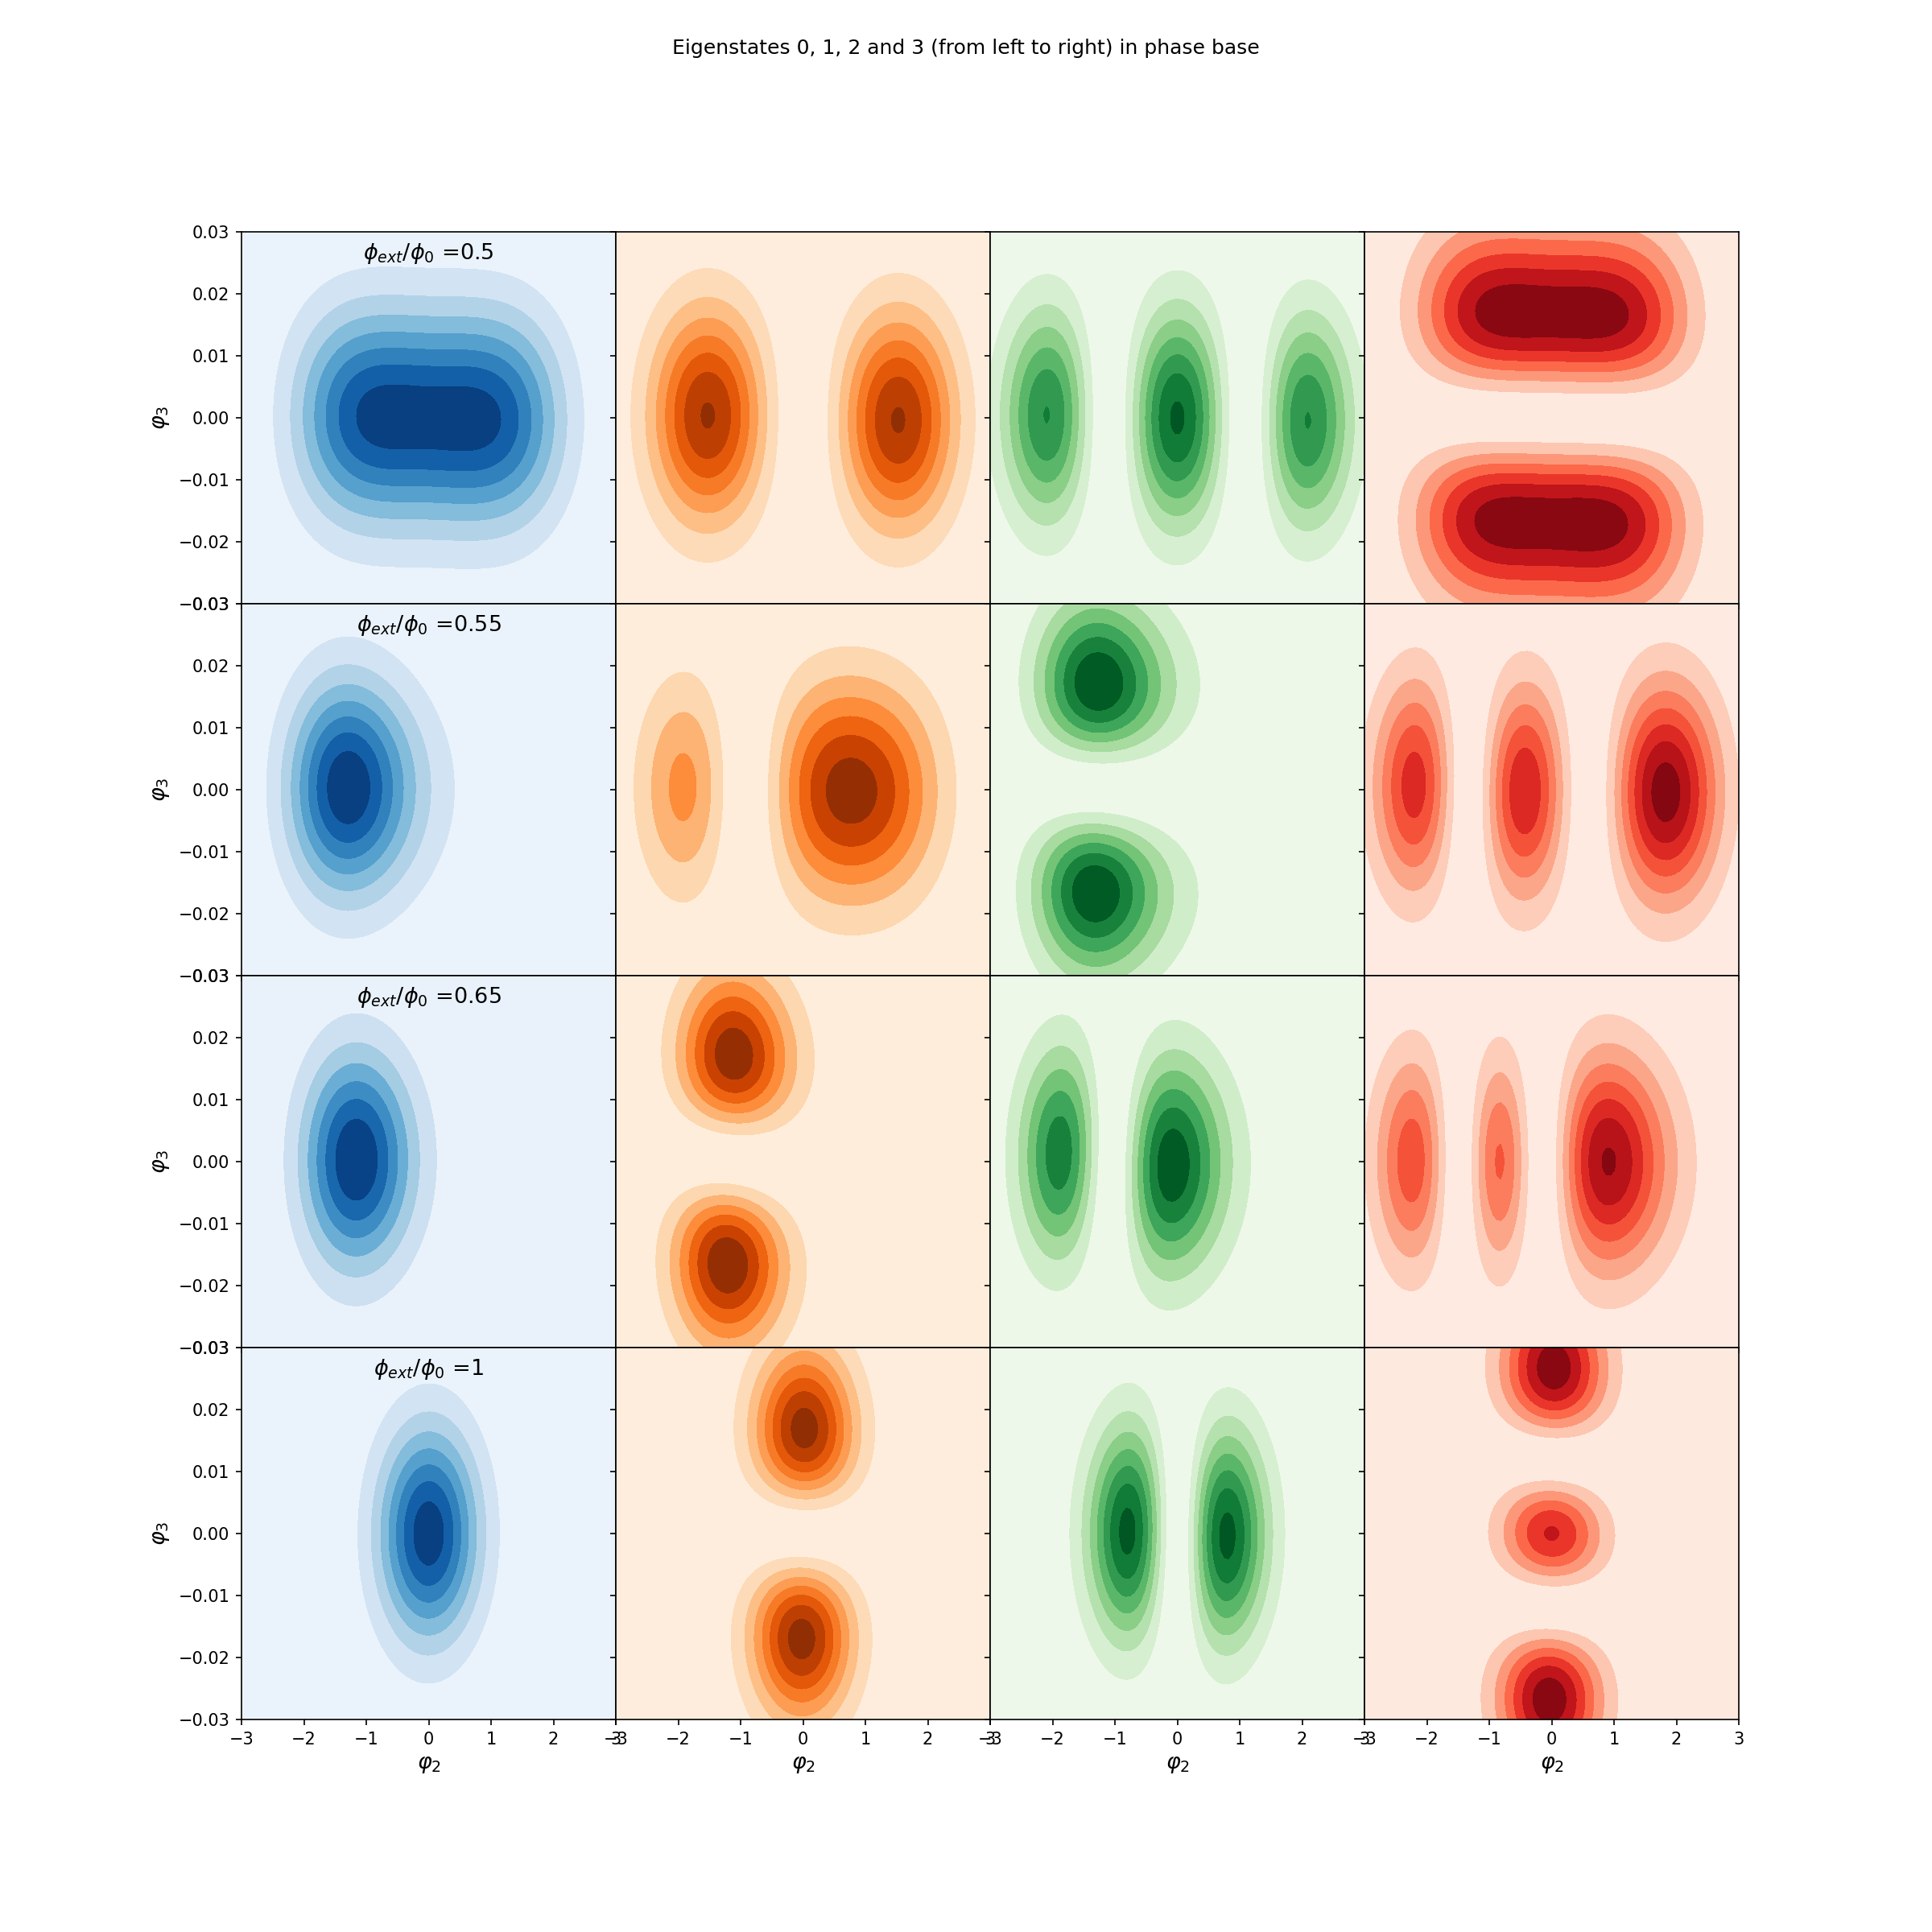

In [21]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4), sharey='row', sharex = 'col', dpi=150)

for i, ext_flux in enumerate(ext_flux_list):
    axs[i, 0].contourf(phi3, phi2, np.abs(state0_vs_ext_flux[i].T) ** 2, cmap="Blues" )
    axs[i, 1].contourf(phi3, phi2, np.abs(state1_vs_ext_flux[i].T) ** 2, cmap="Oranges" )
    axs[i, 2].contourf(phi3, phi2, np.abs(state2_vs_ext_flux[i].T) ** 2, cmap="Greens")
    axs[i, 3].contourf(phi3, phi2, np.abs(state3_vs_ext_flux[i].T) ** 2, cmap="Reds"   )
    if i == 0:
        axs_eigs[1, 0].contourf(phi3, phi2, np.abs(state0_vs_ext_flux[i].T) ** 2, cmap="Blues")
        axs_eigs[1, 0]. set_ylabel(r'$\tilde{\varphi}_R$')
        axs_eigs[1, 0]. set_xlabel(r'$\tilde{\varphi}_F$')
        axs_eigs[1, 0].text(.9,.9, r'$\psi^0$', transform=axs_eigs[1, 0].transAxes, ha="center", va="center")
        axs_eigs[1, 1].contourf(phi3, phi2, np.abs(state1_vs_ext_flux[i].T) ** 2, cmap="Oranges")
        axs_eigs[1, 1]. set_ylabel(r'$\tilde{\varphi}_R$')
        axs_eigs[1, 1]. set_xlabel(r'$\tilde{\varphi}_F$')
        axs_eigs[1, 1].text(.9,.9, r'$\psi^1$', transform=axs_eigs[1, 1].transAxes, ha="center", va="center")
    for j in range(4):
        axs[-1, j].set_xlabel(r"$\varphi_2$", fontsize=13)
    axs[i, 0].set_ylabel(r"$\varphi_3$", fontsize=13)
    axs[i, 0].set_title('$\phi_{ext}/\phi_{0}$ ='+f'{ext_flux}', fontsize=13, y=0.9 )
fig.suptitle('Eigenstates 0, 1, 2 and 3 (from left to right) in phase base')
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
plt.show()

# Eigenstates of the separate and combined systems

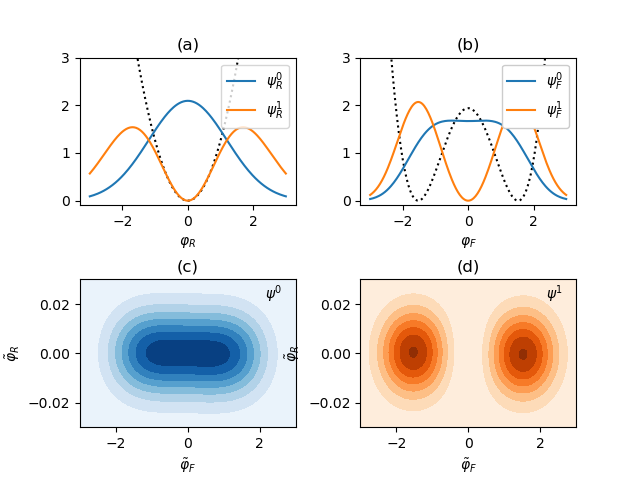

In [22]:
figs.export('Eigenstates.pdf', fig_eigs, hspace=.5, wspace=.3)
fig_eigs.show()

# Fluxonium-Resonator internal coupling in KIT's qubit

### Approach 1: Numerical evaluation of the coupling that has been deduced from the Hamiltonian.

### Approach 1a: Using the fluxonium and resonator circuits.

In [23]:
qubit.set_trunc_nums([1, 15, 15])
resonator.set_trunc_nums([15])
fluxonium.set_trunc_nums([15])

loop.set_flux(0.5)
loop_fluxonium.set_flux(0.5)
# loop_fluxonium.set_flux(0.371)

_ = qubit.diag(2)
_ = fluxonium.diag(2)
_ = resonator.diag(2)

In [24]:
Δ01 = qubit.efreqs[1]- qubit.efreqs[0]
Δ01

1.9453602983438012

In [25]:
H = qubit.hamiltonian_op(0, basis='eig')

In [26]:
sq_ext.decomposition_in_pauli_2x2(qubit.hamiltonian_op(0, basis='eig').__array__())[-1] / GHz /2 /np.pi * -1 * 2

/home/gabriel/PycharmProjects/tunable-capacitive-coupling-flux-qubits/Modules/SQcircuit_extensions.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i] = 0.5 * np.trace(s[i].T.conjugate() @ A)


1.9453602983437936

In [27]:
sq_ext.decomposition_in_pauli_2x2(sq_ext.H_eff_SWT_circuit(qubit, qubit))[-1] / GHz /2 /np.pi * -1 * 2

3.0961370757613965e-10

In [28]:
L_c = l / Δ * 1e-9
E_L_c = (Φ_0/(2*np.pi))**2/L_c / h / GHz
E_L_c

0.010059417635312939

In [29]:
Φ_f = sq_ext.decomposition_in_pauli_2x2(fluxonium.flux_op(0, basis='eig').__array__())[1]
Φ_f

38.419212438911984

In [30]:
# This should be the same as that calculated analytically
Φ_r = sq_ext.decomposition_in_pauli_2x2(resonator.flux_op(0, basis='eig').__array__())[1]
Φ_r

38.365883888557015

In [31]:
g = Φ_r * Φ_f / L_c / GHz  #/ 2 /np.pi
print(g)

0.09070912782598356


In [32]:
g / Δ01 * 100

4.662844610492439

### Approach 2: Analytical approximation of the coupling that has been deduced from the Hamiltonian.

In [33]:
dVdφ =  lambda φ: E_L_f*φ + E_J*np.sin(φ+np.pi)
φ_min = sp.optimize.fsolve(dVdφ, 1)[0]
φ_min

1.5279722082410827

In [34]:
Φ_f_an =(Φ_0 / (2*np.pi)) * φ_min / np.sqrt(sq.hbar)
Φ_f_an

48.968088326233854

In [35]:
# This should be the same as that calculated numerically
Φ_r_an = np.sqrt(1/2 * np.sqrt(L_r/C_r))
Φ_r_an

38.36589667717856

In [36]:
g_an = Φ_f_an * Φ_r_an /L_c  /GHz
g_an

0.11561543774635939

In [37]:
g_an / Δ01 * 100

5.943137517753887

### Approach 3: Extract the coupling by applying the SWT to project the qubit onto the qubit without interaction (Delta=0)

In [38]:
circ_0 = sq_ext.KIT_qubit(Δ=1e-5)
circ = qubit

# circ.loops[0].set_flux(0.372)
# circ_0.loops[0].set_flux(0.372)
circ.loops[0].set_flux(0.5)
circ_0.loops[0].set_flux(0.5)

n_eig = 4
try:
    circ_0.set_trunc_nums([15,15])
except:
    circ_0.set_trunc_nums([1, 15,15])
circ.set_trunc_nums([1,15,15])

_ = circ_0.diag(n_eig)
_ = circ.diag(n_eig)


In [39]:
H_eff = sq_ext.H_eff_SWT_circuit(circ_0, circ_0)
P = sq_ext.decomposition_in_pauli_2x2(H_eff[:2,:2])
E0 = P[0]
Δ_01 = P[-1] * 2
E0, Δ_01

(7.6796462851066805, -1.9453880907015364)

In [40]:
H_eff = sq_ext.H_eff_SWT_circuit(circ_0, circ) - E0*np.eye(len(H_eff))
print(np.round(H_eff, 3))

[[-0.973+0.j -0.   -0.j  0.   -0.j -0.   +0.j]
 [-0.   +0.j  0.974+0.j -0.   +0.j  0.085-0.j]
 [ 0.   +0.j -0.   -0.j  5.188+0.j -0.   +0.j]
 [-0.   -0.j  0.085+0.j -0.   -0.j  6.234+0.j]]


# Number operator

In [58]:
Z = np.sqrt(L_r/C_r)
Z

2943.8840556878818

In [70]:
resonator.set_trunc_nums([15])

In [71]:
_ = resonator.diag(6)

In [72]:
n = 1/2/Z*(resonator.flux_op(0, basis='eig')**2 + Z**2*resonator.charge_op(0, basis='eig')**2)

In [76]:
print(np.round(n,3))

[[ 0.5+0.j  0. +0.j -0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  1.5+0.j  0. +0.j -0. +0.j  0. +0.j  0. +0.j]
 [-0. +0.j  0. +0.j  2.5+0.j  0. +0.j -0. +0.j  0. +0.j]
 [ 0. +0.j -0. +0.j  0. +0.j  3.5+0.j  0. +0.j -0. +0.j]
 [ 0. +0.j  0. +0.j -0. +0.j  0. +0.j  4.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0. +0.j  0. +0.j  2.5+0.j]]


In [80]:
qubit.loops[0].set_flux(0.5)
_ = qubit.diag(6)

In [81]:
n = 1/2/Z*(qubit.flux_op(1, basis='eig')**2 + Z**2*qubit.charge_op(1, basis='eig')**2)

In [85]:
n

Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = False
Qobj data =
[[2.5e+03 0.0e+00 1.7e-02 0.0e+00 3.4e+01 0.0e+00]
 [0.0e+00 2.5e+03 0.0e+00 -3.4e+01 0.0e+00 -3.2e-01]
 [1.7e-02 0.0e+00 9.4e-01 0.0e+00 -3.1e+01 0.0e+00]
 [0.0e+00 -3.4e+01 0.0e+00 2.5e+03 0.0e+00 -1.9e+01]
 [3.4e+01 0.0e+00 -3.1e+01 0.0e+00 2.5e+03 0.0e+00]
 [0.0e+00 -3.2e-01 0.0e+00 -1.9e+01 0.0e+00 7.0e-01]]